In [2]:
from giza_datasets import DatasetsLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
loader = DatasetsLoader()
df = loader.load('tokens-ohcl')
data = df.to_pandas()
data.set_index("date", inplace=True)    # index the date column

# normalize the close column
min_close = data["Close"].min()
max_close = data["Close"].max()
print(f"Min close: {min_close}, Max close: {max_close}")
data["Close"] = (data["Close"] - min_close) / (max_close - min_close)
print(f"Min close: {data['Close'].min()}, Max close: {data['Close'].max()}")
display(data.head())
display(data.tail())

# get the most recent date in the dataset
most_recent_date = data.index.max()
print(f"Most recent date: {most_recent_date}")

Dataset read from cache.
Loading dataset tokens-ohcl from cache.
Min close: 0.0242, Max close: 77849.8442
Min close: 0.0, Max close: 1.0


,Open,High,Low,Close,token
date,,,,,
2019-02-03,3438.3604,3472.2433,3438.3604,0.044458,WBTC
2019-02-07,3468.1600,3486.4073,3425.8603,0.044006,WBTC
2019-02-11,3387.7629,3770.3402,3387.7629,0.048431,WBTC
2019-02-15,3605.9233,3652.9015,3605.5237,0.046314,WBTC
2019-02-19,3613.8624,3831.3850,3613.8624,0.049215,WBTC


,Open,High,Low,Close,token
date,,,,,
2024-01-07,2204.1786,2264.1205,2204.1786,0.028767,FRXETH
2024-01-11,2217.9515,2540.9835,2217.9515,0.032639,FRXETH
2024-01-15,2619.1350,2619.1350,2481.6893,0.031878,FRXETH
2024-01-19,2515.9513,2564.8498,2454.1049,0.031523,FRXETH
2024-01-23,2468.0286,2468.0286,2449.4172,0.031463,FRXETH


Most recent date: 2024-01-23 00:00:00


In [4]:
display(df)

date,Open,High,Low,Close,token
date,f64,f64,f64,f64,str
2019-02-03,3438.3604,3472.2433,3438.3604,3461.0583,"""WBTC"""
2019-02-07,3468.16,3486.4073,3425.8603,3425.8603,"""WBTC"""
2019-02-11,3387.7629,3770.3402,3387.7629,3770.3402,"""WBTC"""
2019-02-15,3605.9233,3652.9015,3605.5237,3605.5237,"""WBTC"""
2019-02-19,3613.8624,3831.385,3613.8624,3831.385,"""WBTC"""
…,…,…,…,…,…
2024-01-07,2204.1786,2264.1205,2204.1786,2239.5087,"""FRXETH"""
2024-01-11,2217.9515,2540.9835,2217.9515,2540.9835,"""FRXETH"""
2024-01-15,2619.135,2619.135,2481.6893,2481.6893,"""FRXETH"""


In [5]:
# Create sequences of n previous closing prices for each row
len_sequence = 61

# Create sequences for each token
sequences = data.groupby('token')['Close'].apply(list).apply(lambda x: [x[i: i + len_sequence] for i in range(len(x)-len_sequence-1)]).to_list()    # shape: (n_tokens, n_sequences_per_token, len_sequence)
print(len(sequences), len(sequences[0]), len(sequences[0][0]))
sequences = np.array([item for sublist in sequences for item in sublist])   # shape: (n_total_sequences, len_sequence)
print(sequences.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences[:, :len_sequence-1], sequences[:, len_sequence-1], test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)  # shape: (n_train_sequences, len_sequence-1)
print("y_train shape:", y_train.shape)  # shape: (n_train_sequences,)
print("X_test shape:", X_test.shape)    # shape: (n_test_sequences, len_sequence-1)
print("y_test shape:", y_test.shape)    # shape: (n_test_sequences,)

# Reshape the input data to add the input dimension (1 in this case)
X_train = np.expand_dims(X_train, axis=-1)  # shape: (n_train_sequences, len_sequence-1, 1)
print("X_train shape:", X_train.shape)
X_test = np.expand_dims(X_test, axis=-1)    # shape: (n_test_sequences, len_sequence-1, 1)
print("X_test shape:", X_test.shape)

30 246 61
(9278, 61)
X_train shape: (7422, 60)
y_train shape: (7422,)
X_test shape: (1856, 60)
y_test shape: (1856,)
X_train shape: (7422, 60, 1)
X_test shape: (1856, 60, 1)


Epoch 1/30


116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0018 - val_loss: 3.0604e-04
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 2.8223e-04 - val_loss: 1.9302e-04
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.4547e-04 - val_loss: 2.5431e-04
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 2.5918e-04 - val_loss: 1.8762e-04
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.4281e-04 - val_loss: 1.3995e-04
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.8208e-04 - val_loss: 1.2218e-04
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 2.1259e-04 - val_loss: 1.3150e-04
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.8656e-04 - val_loss: 1.3696e-04
Epoch 9/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.6838e-04 - val_loss: 1.0526e-04
Epoch 10/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.9096e-04 - val_loss: 1.0051e-04
Epoch 11/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.

Text(0.5, 1.0, 'Loss Evolution')

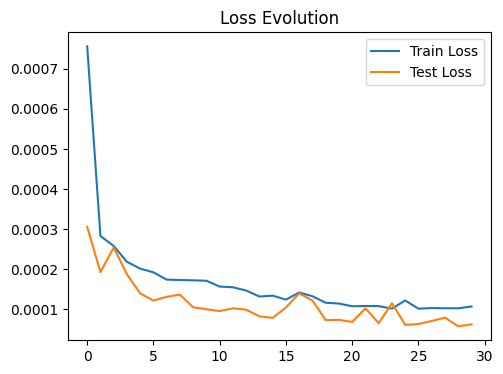

In [156]:
# construct model
training_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

# compile the model
training_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# train the model
history = training_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Loss Evolution')

In [193]:
class InferenceModel(tf.keras.Model):
    def __init__(self, training_model, latest_sequence_per_token, min_close: float, max_close: float):
        super(InferenceModel, self).__init__()
        self.training_model = training_model
        self.min_close = min_close
        self.max_close = max_close
        self.latest_sequence_per_token = tf.constant(latest_sequence_per_token, dtype=tf.float32)  # convert to tensor

    @tf.function
    def call(self, inputs):
        num_intervals = inputs[0]
        num_intervals = tf.cast(num_intervals, dtype=tf.int32)  # convert to int32
        token = inputs[1]
        token = tf.cast(token, dtype=tf.int32)  # convert to int32
        sequence = tf.gather(self.latest_sequence_per_token, token)    # get the latest sequence for the token
        len_sequence = tf.constant(sequence.shape[0], dtype=tf.int32)  # get the length of the sequence

        # Define the loop condition
        def condition(i, sequence):
            return i < num_intervals

        # Define the loop body
        def body(i, sequence):
            inputs = sequence[-len_sequence:]           # get the last sequence
            inputs = tf.expand_dims(inputs, axis=-1)    # add the input dimension
            inputs = tf.expand_dims(inputs, axis=0)     # add the batch dimension
            prediction = self.training_model(inputs)    # predict the closing price for the next interval
            sequence = tf.concat([sequence, prediction[0]], axis=0)             # append the prediction to the sequence
            return i + 1, sequence

        # Use tf.while_loop to construct the loop
        _, final_sequence = tf.while_loop(condition, body, [0, sequence], shape_invariants=[tf.TensorShape([]), tf.TensorShape([None])])

        # denormalize the result
        final_sequence = final_sequence * (self.max_close - self.min_close) + self.min_close

        return final_sequence[-num_intervals:]  # return the last value in the sequence
    

# create a dictionary with the latest sequence for each token
latest_sequence_per_token = [data[data['token'] == token]['Close'].values[-len_sequence:] for token in data['token'].unique()]
tokens = {element:idx for idx, element in enumerate(data['token'].unique())}
print("Tokens: ", tokens)

# construct and save the inference model
inference_model = InferenceModel(training_model, latest_sequence_per_token, min_close, max_close)
inference_model.build(input_shape=(2,))

Tokens:  {'WBTC': 0, 'WETH': 1, 'USDC': 2, 'USDT': 3, 'DAI': 4, 'LINK': 5, 'AAVE': 6, 'STETH': 7, 'WSTETH': 8, 'ETH': 9, 'FRAX': 10, 'RETH': 11, 'YFI': 12, 'MIM': 13, '3CRV': 14, 'ALCX': 15, 'MKR': 16, 'STMATIC': 17, 'WAVAX': 18, 'UNI': 19, 'COMP': 20, 'GNO': 21, 'COW': 22, 'ALUSD': 23, 'SAVAX': 24, 'WMATIC': 25, 'CVX': 26, 'WOO': 27, 'TUSD': 28, 'FRXETH': 29}


In [194]:
# Run the model to predict the closing price on 2024-02-04 for token 'FRXETH'

# get the number of intervals between the most recent date and the target date (interval = 4 days)
target_date = '2024-02-24'
num_intervals = (pd.Timestamp(target_date) - most_recent_date).days // 4
token = tokens['FRXETH']

# predict the closing price for the target date
final_sequence = inference_model(inputs=[num_intervals, token])
print(final_sequence)
print(f"Predicted closing price for token 'BTC' on {target_date}: {final_sequence[-1]}")

tf.Tensor(
[2433.658  2420.7485 2407.601  2394.5706 2381.545  2368.3408 2354.7979
 2340.8022], shape=(8,), dtype=float32)
Predicted closing price for token 'BTC' on 2024-02-24: 2340.80224609375


In [195]:
# Save the model
inference_model.export('TokenPricePredictionModel/0000001')

INFO:tensorflow:Assets written to: TokenPricePredictionModel/0000001\assets


INFO:tensorflow:Assets written to: TokenPricePredictionModel/0000001\assets


Saved artifact at 'TokenPricePredictionModel/0000001'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None,), dtype=tf.float32, name=None)
Captures:
  2352644327728: TensorSpec(shape=(30, 61), dtype=tf.float32, name=None)
  2352783592256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783592608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783592784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783592960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783593136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783593312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783594016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2352783594192: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [196]:
# deploy the model to a TensorFlow Serving container
!docker run -d -p 8501:8501 --name tfserving_token_price_prediction --mount type=bind,source=/c/Users/Moses/Desktop/TokenPricePredictionModel/TokenPricePredictionModel,target=/models/TokenPricePredictionModel -e MODEL_NAME=TokenPricePredictionModel -t tensorflow/serving

ae57c468d10b04df61a578b1b71c53370f7fcc1d92bf9c6c9c2341ee07627f44


In [8]:
# make a request to the container to predict the closing price on 2024-02-04 for token 'FRXETH'

# get the number of intervals between the most recent date and the target date (interval = 4 days)
target_date = '2024-02-04'
num_intervals = (pd.Timestamp(target_date) - most_recent_date).days // 4

# make a request to the TensorFlow Serving container
import requests
import json

url = 'http://44.195.61.90:8501/v1/models/TokenPricePredictionModel:predict'
headers = {"content-type": "application/json"}
data = json.dumps({"signature_name": "serving_default", "instances": [num_intervals, tokens["FRXETH"]]})
response = requests.post(url, data=data, headers=headers)
print(response.json())

TypeError: string indices must be integers, not 'str'